
Branin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=a5d192eb36d51ab232cc3f7e382d984c2d2afe6cf2d1ece4478881fb4c611863
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dERM_GP'
util_grad_approx = 'ExpectedRegret'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedRegret': self.ExpectedRegret,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def ExpectedRegret(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (mean - y_global_orig) * norm.cdf(z) + std * norm.pdf(z)[0]

    def dERM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1651583834.606037

In [13]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.25533007 10.8048674 ]	 -56.52874004692151	 -27.68166689936483	    
init	 [-4.99828438  4.53498859]	 -172.66531086516164	 -27.68166689936483	    
init	 [-2.79866164  1.38507892]	 -102.58290348816024	 -27.68166689936483	    
init	 [-2.20609683  5.18341091]	 -28.868064601155666	 -27.68166689936483	    
init	 [0.95151211 8.08225101]	 -27.68166689936483	 -27.68166689936483	    
1	 [8.41909995 1.27566317]	 -5.089934878453152	 -5.089934878453152	 -1.0125658302513083
2  	 [ 8.98893195 10.45227242]	 -70.52424256621515	 -5.089934878453152	 -1.0125658302497296
3	 [-3.93920149 13.25441417]	 -4.333308116197517	 -4.333308116197517	 -1.012564710482457
4  	 [3.29585328 0.        ]	 -5.167890908848676	 -4.333308116197517	 -1.0125644284881055
5  	 [ 5.36701892 15.        ]	 -206.8589766877631	 -4.333308116197517	 -1.0125643731995226
6  	 [5.81444645 5.67080203]	 -39.335751165739254	 -4.333308116197517	 -1.0125580

In [14]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53992353 0.38889348]	 -22.31361308916297	 -6.692051508754487	    
init	 [3.24493717 6.52983589]	 -19.233109967858276	 -6.692051508754487	    
init	 [1.30551703 4.95502232]	 -13.177851563387286	 -6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 -6.692051508754487	 -6.692051508754487	    
init	 [-0.50517989  4.00240913]	 -26.437522758780958	 -6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 -89.09951357262268	 -6.692051508754487	 -1.0125658302513045
2	 [9.59366035 1.69164323]	 -1.3984593420568778	 -1.3984593420568778	 -1.0125658302512053
3  	 [ 2.76755193 13.40050896]	 -118.04193885354222	 -1.3984593420568778	 -1.0125658223665133
4  	 [-5.          0.73986183]	 -283.24394841613446	 -1.3984593420568778	 -1.0125643351021494
5  	 [-3.14464907 14.56432333]	 -5.605350427804851	 -1.3984593420568778	 -1.0125645448462
6  	 [8.93672669 6.44382594]	 -20.439158338984655	 -1.3984593420568778	 -1.0

In [15]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.26196854 10.62221734]	 -71.68783452098575	 -18.07886746449891	    
init	 [-0.63642892  7.66241408]	 -18.07886746449891	 -18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 -141.98653529865882	 -18.07886746449891	    
init	 [-3.11622034  3.10864317]	 -83.31045707266176	 -18.07886746449891	    
init	 [-4.22799195  6.61214765]	 -76.5294170688398	 -18.07886746449891	    
1  	 [6.70472147 4.59545299]	 -30.726791812855225	 -18.07886746449891	 -1.0125658302513083
2	 [-3.89564496 13.38589781]	 -3.6010193697779265	 -3.6010193697779265	 -1.0125658259845687
3  	 [2.67993826 0.82315258]	 -4.786478981860064	 -3.6010193697779265	 -1.01256354552244
4  	 [10.  0.]	 -10.960889035651505	 -3.6010193697779265	 -1.0125648179178677
5  	 [ 0.48224098 15.        ]	 -113.32534391424977	 -3.6010193697779265	 -1.012516289428922
6  	 [10.          8.34455279]	 -30.47579050396284	 -3.6010193697779265	 -1.01250576438043

In [16]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.50544759 8.20848374]	 -32.51676744781521	 -7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 -66.20566674364716	 -7.247126865776948	    
init	 [5.46593237 3.24134243]	 -20.90089401680587	 -7.247126865776948	    
init	 [9.64411682 0.09345383]	 -7.247126865776948	 -7.247126865776948	    
init	 [-1.20526456  6.52187299]	 -15.941376982363263	 -7.247126865776948	    
1  	 [ 1.25164457 13.57001383]	 -100.61648848019335	 -7.247126865776948	 -1.012565830247625
2  	 [0.4772039 0.       ]	 -46.30149695149086	 -7.247126865776948	 -1.0125657048480399
3  	 [-5.         10.47181678]	 -57.822275371249475	 -7.247126865776948	 -1.012564419558546
4  	 [-4.88534628  1.98852913]	 -232.76751506847782	 -7.247126865776948	 -1.0125645912550554
5  	 [3.92803179 8.48387454]	 -48.675792919740445	 -7.247126865776948	 -1.0125589074328154
6  	 [ 6.50636481 15.        ]	 -212.1977779071447	 -7.247126865776948	 -1.0125379

In [17]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -1.0125658302511973
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -1.0125658297184557
3  	 [-5.          8.51988422]	 -87.84889061009333	 -5.96108856337545	 -1.0125650914209394
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -1.0125562909288441
5  	 [3.88782405 0.        ]	 -6.064787797048776	 -5.96108856337545	 -1.0125474769675202
6  	 [ 3.02988413 15.        ]	 -160.13308160255903	 -5.96108856337545	 -1.0125152835470141
7	 

In [18]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [8.39290227 4.97969708]	 -15.553860636684597	 -15.31731051317483	    
init	 [7.31843685 0.62544939]	 -15.31731051317483	 -15.31731051317483	    
init	 [-3.3851498   8.92578096]	 -16.222288919361837	 -15.31731051317483	    
init	 [2.94726043 6.28211143]	 -15.406373581304088	 -15.31731051317483	    
init	 [0.03111774 9.33779148]	 -31.07053245856209	 -15.31731051317483	    
1  	 [ 9.64829531 12.55362889]	 -98.32295673962142	 -15.31731051317483	 -1.0125658302505929
2  	 [-1.82404332  0.        ]	 -94.69665209951235	 -15.31731051317483	 -1.0125658302511715
3  	 [ 4.34724927 14.59608757]	 -177.48889452505895	 -15.31731051317483	 -1.0125658302513083
4  	 [-2.43400023 14.52854457]	 -17.830335105271345	 -15.31731051317483	 -1.012564763342617
5  	 [-5.         4.2293675]	 -180.63332290289227	 -15.31731051317483	 -1.0125221010799963
6	 [2.86369317 1.58799415]	 -1.6011406937656645	 -1.6011406937656645	 -1.01222

In [19]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.85537566 11.69878188]	 -8.299317850233932	 -5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 -59.50408380701259	 -5.211335324193094	    
init	 [9.66984268 8.07743806]	 -29.714921414987273	 -5.211335324193094	    
init	 [2.51680695 1.080767  ]	 -5.211335324193094	 -5.211335324193094	    
init	 [-0.9734153   7.49823751]	 -15.431057204948033	 -5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 -260.3293952774437	 -5.211335324193094	 -1.0125658302513083
2  	 [ 7.42679792 14.12713902]	 -178.37635728719692	 -5.211335324193094	 -1.0125658194282758
3  	 [8.08940775 0.35854539]	 -9.249625108410735	 -5.211335324193094	 -1.0125656203796176
4  	 [-3.39684884  5.54228873]	 -54.79871094423047	 -5.211335324193094	 -1.0125658302513083
5  	 [4.4720934  5.93920773]	 -27.723638017330405	 -5.211335324193094	 -1.0125610029830903
6  	 [-0.88698611 15.        ]	 -72.11656179914581	 -5.211335324193094	 -1.01

In [20]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 8.10144104 14.52810994]	 -175.17297136347514	 -15.416245468470875	    
init	 [8.0379181  7.96283537]	 -49.32173799887473	 -15.416245468470875	    
init	 [-1.50907508  0.17098206]	 -83.26753461673219	 -15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 -15.416245468470875	 -15.416245468470875	    
init	 [2.84012007 7.17587694]	 -22.49093277852639	 -15.416245468470875	    
1	 [9.77124156 0.43098073]	 -6.499298445992174	 -6.499298445992174	 -1.012565830249782
2  	 [-4.87537438 11.82874897]	 -36.57081146531108	 -6.499298445992174	 -1.0125658302513079
3  	 [-5.          6.18626546]	 -133.74783473476617	 -6.499298445992174	 -1.0125645442626428
4  	 [ 2.00490905 12.66503403]	 -93.13466791376042	 -6.499298445992174	 -1.0125645150333198
5  	 [4.49710607 1.43886209]	 -7.949028807737028	 -6.499298445992174	 -1.012563550885105
6  	 [-1.26517273  9.27145837]	 -13.993955682370324	 -6.499298445992174	 -1.010

In [21]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.84438769  7.52811888]	 -96.15564306553264	 -3.4640248583909496	    
init	 [2.4365994  2.00744293]	 -3.4640248583909496	 -3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 -70.46930174488207	 -3.4640248583909496	    
init	 [1.27762271 3.72151753]	 -12.982825924833865	 -3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 -75.58547400560856	 -3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 -200.4388688685465	 -3.4640248583909496	 -1.0125658302513083
2  	 [-0.46054038 14.56197292]	 -79.4666617606301	 -3.4640248583909496	 -1.012565830220583
3  	 [8.28747407 1.2035024 ]	 -6.196385269800155	 -3.4640248583909496	 -1.0125658093220398
4  	 [5.09988923 9.09295299]	 -75.24675017972764	 -3.4640248583909496	 -1.0125648685944704
5  	 [10.          6.16249821]	 -11.925843837802418	 -3.4640248583909496	 -1.0125621218330914
6  	 [4.22157467e-05 9.30120175e+00]	 -30.50048925898127	 -3.464024858

In [22]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.56980965 0.31127924]	 -19.863985024602144	 -2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 -103.66999147252169	 -2.710610964564512	    
init	 [2.47760518 3.37194968]	 -2.710610964564512	 -2.710610964564512	    
init	 [-2.02905703 11.40796068]	 -8.463930835255017	 -2.710610964564512	    
init	 [-2.46333745  1.32509721]	 -90.49481266026973	 -2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 -158.2412724465548	 -2.710610964564512	 -1.0125658302511882
2  	 [9.65621089 6.61160737]	 -16.1339423373336	 -2.710610964564512	 -1.0125658302513083
3  	 [-3.43070383  6.59407857]	 -41.58407101130534	 -2.710610964564512	 -1.012565829750033
4  	 [-5.         14.87293215]	 -18.080332001739464	 -2.710610964564512	 -1.0125645342843703
5  	 [ 0.92449322 15.        ]	 -123.13234915138221	 -2.710610964564512	 -1.012475570532574
6  	 [1.30728865 7.43276202]	 -23.342263281989574	 -2.710610964564512	 -1.0122

In [23]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.29595467  0.29212862]	 -104.49282729548965	 -22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 -62.47758067812407	 -22.37435843952312	    
init	 [1.30305407 7.28140647]	 -22.37435843952312	 -22.37435843952312	    
init	 [-4.80828778  7.31057411]	 -97.94503054415523	 -22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 -111.62900800771942	 -22.37435843952312	    
1	 [6.94653631 0.95529646]	 -17.615403152614682	 -17.615403152614682	 -1.0125658302513068
2	 [9.95799301 6.93425723]	 -17.51361722617643	 -17.51361722617643	 -1.0125648639219804
3  	 [-2.04991594 15.        ]	 -32.5573558333363	 -17.51361722617643	 -1.0125646020555865
4	 [2.40807729 2.49081214]	 -3.048554877803756	 -3.048554877803756	 -1.0124343062324916
5  	 [ 4.54021256 15.        ]	 -192.3105176444676	 -3.048554877803756	 -1.0123681853483908
6  	 [5.61068086 5.52610486]	 -36.77546338781394	 -3.048554877803756	 -1.01217541501

In [24]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.68755736 11.10074545]	 -1.3827702760021356	 -0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 -14.81231853080056	 -0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 -18.401131000214548	 -0.5499315281120278	    
init	 [8.51072281 0.50132141]	 -5.855172364344769	 -0.5499315281120278	    
init	 [9.35424004 2.05813982]	 -0.5499315281120278	 -0.5499315281120278	    
1  	 [10.          4.44128644]	 -4.011933380719501	 -0.5499315281120278	 -1.0129465536453792
2  	 [ 8.50155249 13.79797306]	 -148.00655208378976	 -0.5499315281120278	 -1.0125658302513083
3  	 [-4.8799499   0.15657603]	 -290.0404981832191	 -0.5499315281120278	 -1.0125658302513083
4  	 [4.43357748 8.80648668]	 -60.98977838199343	 -0.5499315281120278	 -1.012564869822418
5  	 [3.16620827 0.61264314]	 -3.1010288388020264	 -0.5499315281120278	 -1.012564771026435
6  	 [ 1.69015014 13.9447129 ]	 -114.24005453920299	 -0.549931528112

In [25]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.66553616 3.5631183 ]	 -24.823670200298267	 -18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 -188.7803334745195	 -18.038943061558626	    
init	 [9.58901671 6.80173871]	 -18.038943061558626	 -18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 -104.87319703906111	 -18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 -98.03271225790056	 -18.038943061558626	    
1  	 [-3.51870171  3.68338658]	 -91.63196166423945	 -18.038943061558626	 -1.0125658302513083
2	 [-3.06562888 11.40851515]	 -0.8943531028899869	 -0.8943531028899869	 -1.0125658301195273
3  	 [2.3685613 0.       ]	 -11.859175693404021	 -0.8943531028899869	 -1.0125645987432472
4  	 [1.73680198 5.92713917]	 -13.710957542040685	 -0.8943531028899869	 -1.0125592328200026
5  	 [-0.26301224 15.        ]	 -92.75909151223124	 -0.8943531028899869	 -1.012552603923154
6  	 [10.  0.]	 -10.960889035651505	 -0.8943531028899869	 -1.012517397

In [26]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.70915016 11.59747578]	 -81.58264375064097	 -1.4149920024014744	    
init	 [8.05641529 0.12070423]	 -10.148649076616518	 -1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 -79.6056658956529	 -1.4149920024014744	    
init	 [2.69675068 4.77426637]	 -5.855607664288365	 -1.4149920024014744	    
init	 [3.08799906 3.31882414]	 -1.4149920024014744	 -1.4149920024014744	    
1  	 [-5.  0.]	 -308.1290960116068	 -1.4149920024014744	 -1.0125658302513083
2  	 [-3.61083748  7.85924032]	 -32.481990179851884	 -1.4149920024014744	 -1.0125658300965146
3  	 [8.4415984  6.61360555]	 -28.132050221972662	 -1.4149920024014744	 -1.0125658069714676
4  	 [0.61707243 0.        ]	 -43.506647353554065	 -1.4149920024014744	 -1.0125240922576215
5  	 [ 9.81482319 14.16972583]	 -129.85218172547337	 -1.4149920024014744	 -1.0125658302406546
6  	 [-5. 15.]	 -17.508299515778166	 -1.4149920024014744	 -1.0121792015945656
7  	 [

In [27]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.73226546 2.68343887]	 -12.768724532005583	 -12.768724532005583	    
init	 [-4.18455179  5.42307669]	 -95.39334176626551	 -12.768724532005583	    
init	 [-0.86898607  7.95000337]	 -16.419487782111716	 -12.768724532005583	    
init	 [-0.41121626  4.56711539]	 -23.250362743740954	 -12.768724532005583	    
init	 [-3.32388086  3.74848521]	 -80.99796277938532	 -12.768724532005583	    
1  	 [ 6.5655417  11.87699252]	 -134.95011349993544	 -12.768724532005583	 -1.0125658302513063
2  	 [-4.77493765 13.49591113]	 -19.896906503438096	 -12.768724532005583	 -1.0125658297680067
3  	 [ 0.49807252 15.        ]	 -113.70597669512716	 -12.768724532005583	 -1.0125641235934202
4	 [2.5472886 0.       ]	 -9.795500118061007	 -9.795500118061007	 -1.0125632287534874
5  	 [10.          7.39585391]	 -21.24068736039279	 -9.795500118061007	 -1.0125568998225112
6  	 [4.44268491 6.68491057]	 -34.54284958464767	 -9.79550011806100

In [28]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -1.0125658302513083
2  	 [-5.  0.]	 -308.12909601160663	 -2.715864006988424	 -1.0125658194854465
3  	 [10.          6.97628045]	 -17.73044302116918	 -2.715864006988424	 -1.0125658269032534
4  	 [4.63083269 8.53185748]	 -60.07954205917805	 -2.715864006988424	 -1.0125645515162618
5  	 [10.  0.]	 -10.960889035651505	 -2.715864006988424	 -1.012561342416296
6  	 [ 0.52147716 12.42879091]	 -70.50648840607332	 -2.715864006988424	 -1.0125333670228367
7  	 [10.        

In [29]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.58002496  7.95880133]	 -19.016141117164256	 -19.016141117164256	    
init	 [-2.1271882   1.01850537]	 -85.05949339404415	 -19.016141117164256	    
init	 [6.8047819  9.84500283]	 -93.89792695202516	 -19.016141117164256	    
init	 [4.56281344 8.63404341]	 -60.50217141122736	 -19.016141117164256	    
init	 [-4.41405626  5.36720407]	 -110.70834086593878	 -19.016141117164256	    
1	 [9.76575296 0.98553483]	 -4.1623278326263815	 -4.1623278326263815	 -1.0125658302513083
2  	 [-0.36591853 14.49945231]	 -81.3728947682288	 -4.1623278326263815	 -1.0125658274871139
3	 [3.74599703 2.35814314]	 -2.3563457989420957	 -2.3563457989420957	 -1.0125654652466274
4  	 [10.         14.64086749]	 -137.38411051487694	 -2.3563457989420957	 -1.0125641802967016
5  	 [-5.         11.17262384]	 -48.90080592714383	 -2.3563457989420957	 -1.0125607121916416
6  	 [10.          5.64908461]	 -8.945134101750817	 -2.3563457989420957

In [30]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.75561363 7.58180061]	 -49.215059064668324	 -8.150075223157177	    
init	 [8.17902206 2.72760338]	 -8.150075223157177	 -8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 -106.98107856533271	 -8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 -196.08601750690153	 -8.150075223157177	    
init	 [-1.14547366  0.42458888]	 -71.23649635555944	 -8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 -35.58412906267954	 -8.150075223157177	 -1.0125658302513083
2  	 [-1.52468598  7.08270423]	 -13.146058885158528	 -8.150075223157177	 -1.012565074463952
3  	 [ 0.43344746 11.75516361]	 -59.940118096716546	 -8.150075223157177	 -1.0125297500165118
4	 [4.16808622 0.        ]	 -7.621849182200764	 -7.621849182200764	 -1.012533537405389
5	 [3.25051177 4.09052476]	 -4.0607372492488985	 -4.0607372492488985	 -1.012565823569566
6  	 [-5.          3.80328804]	 -191.85713523908967	 -4.0607372492488985	 -1.0124

In [31]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.53699597 11.41874575]	 -4.475608269502271	 -4.475608269502271	    
init	 [-1.2959304   2.07197531]	 -51.13947793770689	 -4.475608269502271	    
init	 [-0.02830155  1.24499348]	 -42.63973921760034	 -4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 -131.17235664506808	 -4.475608269502271	    
init	 [9.74112872 9.53491102]	 -46.84458913925112	 -4.475608269502271	    
1	 [9.57054653 2.03489665]	 -0.8198597583535783	 -0.8198597583535783	 -1.012565830243156
2  	 [4.40529125 4.87644674]	 -18.52616991036314	 -0.8198597583535783	 -1.0125650446124577
3  	 [-5.          6.34895594]	 -130.19475625502412	 -0.8198597583535783	 -1.0125631923070706
4  	 [ 0.06514599 15.        ]	 -102.44880734859521	 -0.8198597583535783	 -1.0125606389321797
5  	 [10. 15.]	 -145.87219087939556	 -0.8198597583535783	 -1.0125584202391222
6  	 [0.56335389 8.5053089 ]	 -29.414039626479212	 -0.8198597583535783	 -1.0125541187465

In [32]:
### ESTIMATED GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.82196202 13.46570592]	 -138.5264349938869	 -14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 -115.63178540512689	 -14.042667401507376	    
init	 [-4.46165622 10.37636373]	 -35.66708529307584	 -14.042667401507376	    
init	 [0.68021413 7.77766418]	 -25.307769914281764	 -14.042667401507376	    
init	 [4.86927198 2.90775327]	 -14.042667401507376	 -14.042667401507376	    
1  	 [-0.18893953  0.75530589]	 -50.23387023383253	 -14.042667401507376	 -1.0125647155717457
2	 [10.          5.85572268]	 -10.081414919460524	 -10.081414919460524	 -1.0125657161956132
3	 [10.          0.35264853]	 -8.967273533850053	 -8.967273533850053	 -1.0125647572000942
4  	 [-4.73527758  0.95407852]	 -249.82029022592297	 -8.967273533850053	 -1.0125657710522113
5  	 [-1.6852651 15.       ]	 -44.31668151122228	 -8.967273533850053	 -1.0125576383815542
6  	 [5.59674382 7.78244529]	 -61.56236880519019	 -8.967273533850053	 -

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1651584003.2648053

In [34]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 1.25533007 10.8048674 ]	 -56.52874004692151	 -27.68166689936483	    
init	 [-4.99828438  4.53498859]	 -172.66531086516164	 -27.68166689936483	    
init	 [-2.79866164  1.38507892]	 -102.58290348816024	 -27.68166689936483	    
init	 [-2.20609683  5.18341091]	 -28.868064601155666	 -27.68166689936483	    
init	 [0.95151211 8.08225101]	 -27.68166689936483	 -27.68166689936483	    
1	 [8.41909995 1.27566317]	 -5.089934878453152	 -5.089934878453152	 -1.012565731570635
2  	 [ 8.98893195 10.45227242]	 -70.52424256621515	 -5.089934878453152	 -1.0125657315690562
3  	 [3.24709681 0.02115122]	 -5.173244296289956	 -5.089934878453152	 -1.0125645541734336
4  	 [-4.67712792 14.21955317]	 -13.865244792739254	 -5.089934878453152	 -1.0125657304814113
5  	 [ 5.28828699 15.        ]	 -205.7740594331423	 -5.089934878453152	 -1.012564310624116
6  	 [5.68448723 6.090452  ]	 -42.565414798707565	 -5.089934878453152	 -1.01254

In [35]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.53992353 0.38889348]	 -22.31361308916297	 -6.692051508754487	    
init	 [3.24493717 6.52983589]	 -19.233109967858276	 -6.692051508754487	    
init	 [1.30551703 4.95502232]	 -13.177851563387286	 -6.692051508754487	    
init	 [-1.93027049  9.2890645 ]	 -6.692051508754487	 -6.692051508754487	    
init	 [-0.50517989  4.00240913]	 -26.437522758780958	 -6.692051508754487	    
1  	 [ 9.5587047  12.00387527]	 -89.09951357262268	 -6.692051508754487	 -1.0125657315706311
2	 [9.59366035 1.69164323]	 -1.3984593420568778	 -1.3984593420568778	 -1.0125657315705319
3  	 [ 3.24245232 12.67669673]	 -110.25694222671481	 -1.3984593420568778	 -1.0125656429429475
4  	 [-5.  0.]	 -308.12909601160663	 -1.3984593420568778	 -1.0125656269526828
5  	 [9.02394693 6.38201831]	 -19.00430028763514	 -1.3984593420568778	 -1.0125566147966443
6  	 [-3.95509114 14.02730345]	 -3.48680055844817	 -1.3984593420568778	 -1.0125624075263404

In [36]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.26196854 10.62221734]	 -71.68783452098575	 -18.07886746449891	    
init	 [-0.63642892  7.66241408]	 -18.07886746449891	 -18.07886746449891	    
init	 [ 8.39420432 13.44439633]	 -141.98653529865882	 -18.07886746449891	    
init	 [-3.11622034  3.10864317]	 -83.31045707266176	 -18.07886746449891	    
init	 [-4.22799195  6.61214765]	 -76.5294170688398	 -18.07886746449891	    
1  	 [6.70472147 4.59545299]	 -30.726791812855225	 -18.07886746449891	 -1.012565731570635
2	 [-3.89564496 13.38589781]	 -3.6010193697779265	 -3.6010193697779265	 -1.012565727303895
3  	 [ 0.49219244 15.        ]	 -113.5648734358273	 -3.6010193697779265	 -1.0125161830507194
4  	 [3.31497689 0.        ]	 -5.137169559364589	 -3.6010193697779265	 -1.01256499313867
5  	 [10.          8.34527826]	 -30.48354136249052	 -3.6010193697779265	 -1.0125056652127706
6  	 [9.93677706 0.73582747]	 -6.490866332170537	 -3.6010193697779265	 -1.012

In [37]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.50544759 8.20848374]	 -32.51676744781521	 -7.247126865776948	    
init	 [ 9.5902654  10.72223991]	 -66.20566674364716	 -7.247126865776948	    
init	 [5.46593237 3.24134243]	 -20.90089401680587	 -7.247126865776948	    
init	 [9.64411682 0.09345383]	 -7.247126865776948	 -7.247126865776948	    
init	 [-1.20526456  6.52187299]	 -15.941376982363263	 -7.247126865776948	    
1  	 [ 1.25164457 13.57001383]	 -100.61648848019335	 -7.247126865776948	 -1.0125657315669516
2  	 [-4.27198795  1.64727177]	 -188.41076037632916	 -7.247126865776948	 -1.0125654418103283
3  	 [1.24680796 0.        ]	 -30.835406601599388	 -7.247126865776948	 -1.012558000132688
4  	 [ 6.62356632 15.        ]	 -211.54458919378212	 -7.247126865776948	 -1.0125353252902756
5  	 [-4.73699493 13.33053872]	 -19.892240270122997	 -7.247126865776948	 -1.0125652702272916
6  	 [-5.          8.03524818]	 -96.48490483669138	 -7.247126865776948	 -1.0

In [38]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.67010243 13.06098459]	 -25.390690545664548	 -25.311309190989615	    
init	 [-1.89921267 13.77916362]	 -25.311309190989615	 -25.311309190989615	    
init	 [2.32616783 9.17615794]	 -41.60147975414021	 -25.311309190989615	    
init	 [6.48861785 7.77626982]	 -63.81281921768236	 -25.311309190989615	    
init	 [-0.54799248  2.81581843]	 -34.966203644931994	 -25.311309190989615	    
1	 [8.84124421 0.03321319]	 -5.96108856337545	 -5.96108856337545	 -1.0125657315705239
2  	 [ 8.39476442 14.47736321]	 -167.21523769473345	 -5.96108856337545	 -1.0125657310377822
3  	 [-5.          8.50731558]	 -88.06692538826472	 -5.96108856337545	 -1.0125650341399817
4  	 [-5.  0.]	 -308.12909601160663	 -5.96108856337545	 -1.01255619224805
5  	 [4.68269035 2.64603605]	 -11.31779144014903	 -5.96108856337545	 -1.0125373603618433
6  	 [ 3.03229916 15.        ]	 -160.17986849640116	 -5.96108856337545	 -1.0125151812796327
7	 [1

In [39]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [8.39290227 4.97969708]	 -15.553860636684597	 -15.31731051317483	    
init	 [7.31843685 0.62544939]	 -15.31731051317483	 -15.31731051317483	    
init	 [-3.3851498   8.92578096]	 -16.222288919361837	 -15.31731051317483	    
init	 [2.94726043 6.28211143]	 -15.406373581304088	 -15.31731051317483	    
init	 [0.03111774 9.33779148]	 -31.07053245856209	 -15.31731051317483	    
1  	 [ 9.64829531 12.55362889]	 -98.32295673962142	 -15.31731051317483	 -1.0125657315699195
2  	 [-1.22578785  0.62063252]	 -69.8637190838968	 -15.31731051317483	 -1.0125657314897942
3  	 [ 1.3395746  14.83539323]	 -127.45307783921733	 -15.31731051317483	 -1.0125646872858847
4  	 [-5.          4.21567906]	 -180.98825955860133	 -15.31731051317483	 -1.0125209006174956
5  	 [ 4.82185171 10.81025099]	 -100.93632097217323	 -15.31731051317483	 -1.0124265774062047
6	 [-3.4990027  13.45496615]	 -1.0974162749042282	 -1.0974162749042282	 -1.0

In [40]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.85537566 11.69878188]	 -8.299317850233932	 -5.211335324193094	    
init	 [ 1.57613847 10.85197767]	 -59.50408380701259	 -5.211335324193094	    
init	 [9.66984268 8.07743806]	 -29.714921414987273	 -5.211335324193094	    
init	 [2.51680695 1.080767  ]	 -5.211335324193094	 -5.211335324193094	    
init	 [-0.9734153   7.49823751]	 -15.431057204948033	 -5.211335324193094	    
1  	 [-4.97859679  1.38393519]	 -260.3293952774437	 -5.211335324193094	 -1.012565731570635
2  	 [ 7.42679792 14.12713902]	 -178.37635728719692	 -5.211335324193094	 -1.0125657207476022
3  	 [8.08940775 0.35854539]	 -9.249625108410735	 -5.211335324193094	 -1.0125655216989415
4  	 [-3.39684884  5.54228873]	 -54.79871094423047	 -5.211335324193094	 -1.012565731570635
5  	 [4.94544954 5.5071879 ]	 -30.014161847547594	 -5.211335324193094	 -1.012556749198028
6  	 [-0.82354444 15.        ]	 -74.31125853225242	 -5.211335324193094	 -1.01228

In [41]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 8.10144104 14.52810994]	 -175.17297136347514	 -15.416245468470875	    
init	 [8.0379181  7.96283537]	 -49.32173799887473	 -15.416245468470875	    
init	 [-1.50907508  0.17098206]	 -83.26753461673219	 -15.416245468470875	    
init	 [1.45703227 6.0352704 ]	 -15.416245468470875	 -15.416245468470875	    
init	 [2.84012007 7.17587694]	 -22.49093277852639	 -15.416245468470875	    
1	 [9.77124156 0.43098073]	 -6.499298445992174	 -6.499298445992174	 -1.0125657315691086
2  	 [-4.87537438 11.82874897]	 -36.57081146531108	 -6.499298445992174	 -1.0125657315706345
3  	 [ 0.45081738 13.94638662]	 -93.25142611098795	 -6.499298445992174	 -1.012564953857149
4  	 [4.47251591 0.866383  ]	 -8.078155973488538	 -6.499298445992174	 -1.0125639723663264
5  	 [-4.06875054  6.05187677]	 -77.55161170327132	 -6.499298445992174	 -1.0125643690740376
6  	 [-1.07541354  9.60963765]	 -17.62235362551366	 -6.499298445992174	 -1.0103

In [42]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.84438769  7.52811888]	 -96.15564306553264	 -3.4640248583909496	    
init	 [2.4365994  2.00744293]	 -3.4640248583909496	 -3.4640248583909496	    
init	 [-2.86833372  3.27838013]	 -70.46930174488207	 -3.4640248583909496	    
init	 [1.27762271 3.72151753]	 -12.982825924833865	 -3.4640248583909496	    
init	 [-3.73910523  5.1824796 ]	 -75.58547400560856	 -3.4640248583909496	    
1  	 [ 7.05609655 14.75038872]	 -200.4388688685465	 -3.4640248583909496	 -1.012565731570635
2  	 [-0.46054038 14.56197292]	 -79.4666617606301	 -3.4640248583909496	 -1.0125657315399097
3  	 [8.28747407 1.2035024 ]	 -6.196385269800155	 -3.4640248583909496	 -1.0125657106413661
4  	 [4.00818884 9.58112639]	 -65.95553030943105	 -3.4640248583909496	 -1.012564845436485
5  	 [10.          7.36889848]	 -21.004589149340347	 -3.4640248583909496	 -1.0125657028347028
6  	 [6.12749834 4.72723949]	 -32.65608244198498	 -3.4640248583909496	 

In [43]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.56980965 0.31127924]	 -19.863985024602144	 -2.710610964564512	    
init	 [ 4.50472352 11.23205824]	 -103.66999147252169	 -2.710610964564512	    
init	 [2.47760518 3.37194968]	 -2.710610964564512	 -2.710610964564512	    
init	 [-2.02905703 11.40796068]	 -8.463930835255017	 -2.710610964564512	    
init	 [-2.46333745  1.32509721]	 -90.49481266026973	 -2.710610964564512	    
1  	 [ 9.16391068 14.81438212]	 -158.2412724465548	 -2.710610964564512	 -1.0125657315705145
2  	 [9.65621089 6.61160737]	 -16.1339423373336	 -2.710610964564512	 -1.012565731570635
3  	 [-3.43070383  6.59407857]	 -41.58407101130534	 -2.710610964564512	 -1.0125657310693597
4  	 [ 0.88935699 15.        ]	 -122.41215109414165	 -2.710610964564512	 -1.0125646866420912
5  	 [5.26536588 6.20072713]	 -40.03620701932327	 -2.710610964564512	 -1.0119201694094981
6  	 [1.92213987 0.        ]	 -18.37879825106873	 -2.710610964564512	 -1.0094533

In [44]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.29595467  0.29212862]	 -104.49282729548965	 -22.37435843952312	    
init	 [ 1.9482779  10.87400894]	 -62.47758067812407	 -22.37435843952312	    
init	 [1.30305407 7.28140647]	 -22.37435843952312	 -22.37435843952312	    
init	 [-4.80828778  7.31057411]	 -97.94503054415523	 -22.37435843952312	    
init	 [ 9.12709979 12.76192634]	 -111.62900800771942	 -22.37435843952312	    
1	 [6.94653631 0.95529646]	 -17.615403152614682	 -17.615403152614682	 -1.0125657315706333
2	 [9.18257738 6.04096973]	 -14.836006875517853	 -14.836006875517853	 -1.0125647140401697
3	 [2.57274635 0.        ]	 -9.529930973982662	 -9.529930973982662	 -1.0121327730290304
4  	 [6.00460921 9.21015297]	 -84.98773163386197	 -9.529930973982662	 -1.0107088584862438
5  	 [ 4.56481756 15.        ]	 -192.82106325520704	 -9.529930973982662	 -1.012366989627352
6	 [-2.55282032 11.48893614]	 -2.355851786361387	 -2.355851786361387	 -1.0116085351

In [45]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-2.68755736 11.10074545]	 -1.3827702760021356	 -0.5499315281120278	    
init	 [-1.05027477  8.0060909 ]	 -14.81231853080056	 -0.5499315281120278	    
init	 [-4.78137556 13.78120512]	 -18.401131000214548	 -0.5499315281120278	    
init	 [8.51072281 0.50132141]	 -5.855172364344769	 -0.5499315281120278	    
init	 [9.35424004 2.05813982]	 -0.5499315281120278	 -0.5499315281120278	    
1  	 [10.          4.30416863]	 -3.636293400304428	 -0.5499315281120278	 -1.0128967253792414
2  	 [ 9.19833734 12.85785838]	 -112.3096138370831	 -0.5499315281120278	 -1.012565731570635
3  	 [-4.8799499   0.15657603]	 -290.0404981832191	 -0.5499315281120278	 -1.0125657315706347
4  	 [1.89159848 0.57192205]	 -15.265125065800465	 -0.5499315281120278	 -1.012565722549757
5  	 [ 0.90630086 15.        ]	 -122.76062232846587	 -0.5499315281120278	 -1.0125651888214058
6  	 [5.12931711 8.56003383]	 -67.54059008909404	 -0.5499315281120

In [46]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [6.66553616 3.5631183 ]	 -24.823670200298267	 -18.038943061558626	    
init	 [ 7.36417799 14.48623797]	 -188.7803334745195	 -18.038943061558626	    
init	 [9.58901671 6.80173871]	 -18.038943061558626	 -18.038943061558626	    
init	 [ 4.13563694 11.63289772]	 -104.87319703906111	 -18.038943061558626	    
init	 [ 4.62420017 10.83027344]	 -98.03271225790056	 -18.038943061558626	    
1  	 [-3.51870171  3.68338658]	 -91.63196166423945	 -18.038943061558626	 -1.012565731570635
2	 [-3.06562888 11.40851515]	 -0.8943531028899869	 -0.8943531028899869	 -1.0125657314388536
3  	 [2.22555486 0.        ]	 -13.748879685908804	 -0.8943531028899869	 -1.0125650706330327
4  	 [1.45066852 6.21135436]	 -16.205579709602702	 -0.8943531028899869	 -1.0125573246457154
5  	 [-0.02228696 13.86809438]	 -80.94871489112535	 -0.8943531028899869	 -1.012096043890823
6  	 [-5.          8.23487072]	 -92.87081848692483	 -0.89435310288998

In [47]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 2.70915016 11.59747578]	 -81.58264375064097	 -1.4149920024014744	    
init	 [8.05641529 0.12070423]	 -10.148649076616518	 -1.4149920024014744	    
init	 [-0.35396112 14.36405609]	 -79.6056658956529	 -1.4149920024014744	    
init	 [2.69675068 4.77426637]	 -5.855607664288365	 -1.4149920024014744	    
init	 [3.08799906 3.31882414]	 -1.4149920024014744	 -1.4149920024014744	    
1  	 [10.          9.77645093]	 -47.823366031636674	 -1.4149920024014744	 -1.012565731557746
2  	 [-3.61083748  7.85924032]	 -32.481990179851884	 -1.4149920024014744	 -1.012565731417155
3  	 [-0.5369506  0.       ]	 -65.74814342277702	 -1.4149920024014744	 -1.012564829127338
4  	 [-5.          2.79941019]	 -219.73685262933344	 -1.4149920024014744	 -1.0125379711510327
5  	 [ 7.44802367 15.        ]	 -201.14330599451029	 -1.4149920024014744	 -1.012564136767562
6  	 [10.          4.59999645]	 -4.493676938063431	 -1.414992002401474

In [48]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.73226546 2.68343887]	 -12.768724532005583	 -12.768724532005583	    
init	 [-4.18455179  5.42307669]	 -95.39334176626551	 -12.768724532005583	    
init	 [-0.86898607  7.95000337]	 -16.419487782111716	 -12.768724532005583	    
init	 [-0.41121626  4.56711539]	 -23.250362743740954	 -12.768724532005583	    
init	 [-3.32388086  3.74848521]	 -80.99796277938532	 -12.768724532005583	    
1  	 [ 6.5655417  11.87699252]	 -134.95011349993544	 -12.768724532005583	 -1.0125657315706327
2  	 [-4.77493765 13.49591113]	 -19.896906503438096	 -12.768724532005583	 -1.0125657310873335
3  	 [ 1.21146284 15.        ]	 -128.69210522895327	 -12.768724532005583	 -1.0125655234189217
4	 [2.54720482 0.07864599]	 -9.364642237420483	 -9.364642237420483	 -1.0125620454016626
5  	 [9.99501649 7.39458825]	 -21.247060417486146	 -9.364642237420483	 -1.0125566733503688
6  	 [4.31404749 6.82491505]	 -34.22443290077146	 -9.3646422374204

In [49]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -1.012565731570635
2  	 [-5.          0.77723009]	 -282.01611609418495	 -2.715864006988424	 -1.0125656243255747
3  	 [10.          5.64059168]	 -8.900259472871072	 -2.715864006988424	 -1.01256515674148
4  	 [4.11243132 8.80009307]	 -55.85062737292832	 -2.715864006988424	 -1.0125646116683593
5  	 [-5.         10.28108353]	 -60.42040928471862	 -2.715864006988424	 -1.0116301412211568
6  	 [10.         10.86618331]	 -63.773474833133626	 -2.715864006988424	 -1.0125

In [50]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-0.58002496  7.95880133]	 -19.016141117164256	 -19.016141117164256	    
init	 [-2.1271882   1.01850537]	 -85.05949339404415	 -19.016141117164256	    
init	 [6.8047819  9.84500283]	 -93.89792695202516	 -19.016141117164256	    
init	 [4.56281344 8.63404341]	 -60.50217141122736	 -19.016141117164256	    
init	 [-4.41405626  5.36720407]	 -110.70834086593878	 -19.016141117164256	    
1	 [9.76575296 0.98553483]	 -4.1623278326263815	 -4.1623278326263815	 -1.012565731570635
2  	 [-0.36591853 14.49945231]	 -81.3728947682288	 -4.1623278326263815	 -1.0125657288064405
3	 [3.74599703 2.35814314]	 -2.3563457989420957	 -2.3563457989420957	 -1.0125653665659493
4  	 [10.         14.83591807]	 -141.96211758268552	 -2.3563457989420957	 -1.012565096303977
5  	 [9.40340415 5.54620471]	 -9.943082500300157	 -2.3563457989420957	 -1.0124411544937797
6  	 [-5.         11.25245434]	 -47.946860113766995	 -2.3563457989420957	 -

In [51]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [4.75561363 7.58180061]	 -49.215059064668324	 -8.150075223157177	    
init	 [8.17902206 2.72760338]	 -8.150075223157177	 -8.150075223157177	    
init	 [ 7.78349603 11.25204429]	 -106.98107856533271	 -8.150075223157177	    
init	 [ 4.99152501 14.81843172]	 -196.08601750690153	 -8.150075223157177	    
init	 [-1.14547366  0.42458888]	 -71.23649635555944	 -8.150075223157177	    
1  	 [-4.83474958 11.77354131]	 -35.58412906267954	 -8.150075223157177	 -1.012565731570635
2  	 [-0.88714687  6.68331353]	 -16.754341712767037	 -8.150075223157177	 -1.0125645000183963
3  	 [9.35886801 6.57464658]	 -17.680117241533345	 -8.150075223157177	 -1.0125644223768393
4  	 [-0.63498014 15.        ]	 -80.73140113884219	 -8.150075223157177	 -1.0125499160282307
5  	 [-0.12756076 10.65515995]	 -39.32694072953375	 -8.150075223157177	 -1.012565731424965
6	 [4.16504649 0.        ]	 -7.6019478359455075	 -7.6019478359455075	 -1.012

In [52]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-3.53699597 11.41874575]	 -4.475608269502271	 -4.475608269502271	    
init	 [-1.2959304   2.07197531]	 -51.13947793770689	 -4.475608269502271	    
init	 [-0.02830155  1.24499348]	 -42.63973921760034	 -4.475608269502271	    
init	 [ 5.07965622 12.09890697]	 -131.17235664506808	 -4.475608269502271	    
init	 [9.74112872 9.53491102]	 -46.84458913925112	 -4.475608269502271	    
1	 [9.57054653 2.03489665]	 -0.8198597583535783	 -0.8198597583535783	 -1.0125657315624823
2  	 [4.94894051 4.56545987]	 -22.995257753719198	 -0.8198597583535783	 -1.012565334217903
3  	 [-5.          6.36422973]	 -129.86390264478524	 -0.8198597583535783	 -1.0125630932859733
4  	 [ 0.09498041 15.        ]	 -103.28134455168016	 -0.8198597583535783	 -1.0125605563490632
5  	 [10. 15.]	 -145.87219087939556	 -0.8198597583535783	 -1.0125583215583662
6  	 [0.40358398 9.24732989]	 -33.79683336886079	 -0.8198597583535783	 -1.0124999005348

In [53]:
### EXACT GP ERM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 3.82196202 13.46570592]	 -138.5264349938869	 -14.042667401507376	    
init	 [ 8.37296094 12.23756216]	 -115.63178540512689	 -14.042667401507376	    
init	 [-4.46165622 10.37636373]	 -35.66708529307584	 -14.042667401507376	    
init	 [0.68021413 7.77766418]	 -25.307769914281764	 -14.042667401507376	    
init	 [4.86927198 2.90775327]	 -14.042667401507376	 -14.042667401507376	    
1  	 [0.14992375 0.        ]	 -52.72147028896617	 -14.042667401507376	 -1.0125648673198404
2	 [10.          5.64843486]	 -8.941695868504478	 -8.941695868504478	 -1.012565545580381
3  	 [-5.          4.78158886]	 -166.62691093349147	 -8.941695868504478	 -1.0125642981070102
4  	 [-2.33777373 13.96317816]	 -15.843176720593151	 -8.941695868504478	 -1.0125648262389706
5  	 [-5.  0.]	 -308.12909601160663	 -8.941695868504478	 -1.0120162357633602
6	 [9.19905437 0.83066952]	 -2.7745590618899953	 -2.7745590618899953	 -1.0125086847655

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

342.18915247917175

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.3700178942367358, 0.4647841999154631)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(0.0005721783316311656, 0.0005721783316311656)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(0.5886557506760689, 1.164129196584808)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(0.9093018111040746, 0.04685686771131252)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.2009407200657494, 0.2798562296647548)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.18502929902031712, -0.7853730592494456)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.7868206601641746, -0.14978798288142878)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.0741475238762823, 0.4572820101202621)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.45303178589525894, 0.5941651047479486)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.6062647559923829, 0.7664260555342787)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.4375409096198029, 0.16625211626847194)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.42947263259769924, 1.1750813570475924)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(-0.7002400699524578, -0.7002400699524578)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-0.6986095103445964, 0.5834871186666485)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.7622468675665529, 0.11505526150196381)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.7981624508188385, -0.9361209721049353)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.4428317913917495, 0.3736586777309275)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.298241600965053, 0.8492921127985363)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-2.8682738120274913, -0.8628145206943092)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(0.7435427963733635, 0.8657012158354602)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

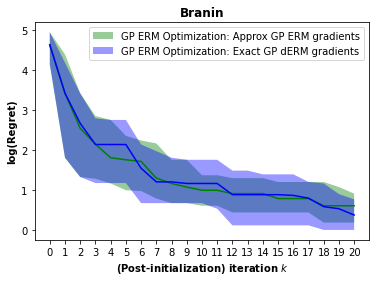

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(168.65867066383362, 342.18915247917175)

In [100]:
exact21_results, exact21_results[19:20].index[0]


(           0
 11  1.175081
 2   1.164129
 19  0.865701
 17  0.849292
 9   0.766426
 8   0.594165
 13  0.583487
 0   0.464784
 7   0.457282
 16  0.373659
 4   0.279856
 10  0.166252
 14  0.115055
 3   0.046857
 1   0.000572
 6  -0.149788
 12 -0.700240
 5  -0.785373
 18 -0.862815
 15 -0.936121, 15)

In [101]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'16'

In [102]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-2.619342142647559, -0.9978631535958269, 0.7981624508188385)

In [103]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -1.0125658302513083
2  	 [-5.  0.]	 -308.12909601160663	 -2.715864006988424	 -1.0125658194854465
3  	 [10.          6.97628045]	 -17.73044302116918	 -2.715864006988424	 -1.0125658269032534
4  	 [4.63083269 8.53185748]	 -60.07954205917805	 -2.715864006988424	 -1.0125645515162618
5  	 [10.  0.]	 -10.960889035651505	 -2.715864006988424	 -1.012561342416296
6  	 [ 0.52147716 12.42879091]	 -70.50648840607332	 -2.715864006988424	 -1.0125333670228367
7  	 [10.        

In [104]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[-1.65590302,  4.87424845],
        [ 4.15981416,  0.        ],
        [-2.66100575,  0.67643999],
        [-3.22591516,  4.42705884],
        [ 4.10900278,  5.88382768],
        [10.        ,  4.12942532],
        [ 2.08733066, 15.        ],
        [ 0.09785399,  1.62063466],
        [ 2.56778141, 10.48650954],
        [-0.53289528, 14.88786288],
        [ 4.10895769,  5.88384975],
        [-3.54062933,  7.97850452],
        [ 7.8649082 ,  9.1375666 ],
        [ 9.73335524, 14.38169583],
        [-2.39891007,  2.84586091],
        [ 0.67618203,  9.27310336],
        [-2.70983305, 12.19319817],
        [-2.70982727, 12.19319155],
        [ 2.42485788, 13.25028472],
        [ 9.0300743 , 14.3658936 ]]),
 array([-0.62, -0.49, -0.  , -0.  , -0.09, -0.58, -0.7 , -0.  , -0.  ,
        -0.  , -0.09, -0.23, -0.82, -0.  , -0.72, -0.67, -0.62, -0.62,
        -0.  , -0.  ]),
 array([7.8649082, 9.1375666]),
 array([7.8649082, 9.1375666]))

In [105]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_maxAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_simpleRegret


(-0.7900330342927973, -1.0091169806581173, -0.9361209721049353)

In [106]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65063381  7.84745012]	 -10.514702126319445	 -2.715864006988424	    
init	 [3.26052185 0.68402925]	 -2.715864006988424	 -2.715864006988424	    
init	 [0.41093253 3.34621413]	 -22.889515127492515	 -2.715864006988424	    
init	 [5.33089243 2.45597138]	 -17.178157611778595	 -2.715864006988424	    
init	 [-3.945127  14.1151629]	 -3.3649224341694195	 -2.715864006988424	    
1  	 [ 5.63879248 14.58068289]	 -198.51319639462758	 -2.715864006988424	 -1.012565731570635
2  	 [-5.          0.77723009]	 -282.01611609418495	 -2.715864006988424	 -1.0125656243255747
3  	 [10.          5.64059168]	 -8.900259472871072	 -2.715864006988424	 -1.01256515674148
4  	 [4.11243132 8.80009307]	 -55.85062737292832	 -2.715864006988424	 -1.0125646116683593
5  	 [-5.         10.28108353]	 -60.42040928471862	 -2.715864006988424	 -1.0116301412211568
6  	 [10.         10.86618331]	 -63.773474833133626	 -2.715864006988424	 -1.0125

In [107]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned, then multiply by -1 (NB!)


(array([[-2.93335315,  4.98430225],
        [ 3.14852899,  3.56801186],
        [-2.66100575,  0.67643999],
        [-3.22591516,  4.42705884],
        [ 3.25028298,  6.0635718 ],
        [ 6.82576035,  0.        ],
        [ 1.5690007 , 13.87289205],
        [ 0.51160332,  2.03438399],
        [ 2.56778141, 10.48650954],
        [-0.53289528, 14.88786288],
        [ 5.30030441,  5.46276633],
        [ 1.53504086,  7.94942878],
        [ 7.83220417,  7.30970198],
        [ 9.73335524, 14.38169583],
        [-1.59990126,  2.37758914],
        [ 0.81304767,  8.74970855],
        [-2.93963106, 15.        ],
        [-2.65185957, 12.64620691],
        [ 2.42485547, 13.25024333],
        [ 9.0300743 , 14.3658936 ]]),
 array([-0.  , -0.59, -0.  , -0.  , -0.04, -0.93, -0.  , -0.  , -0.  ,
        -0.  , -0.  , -0.19, -0.25, -0.  , -0.12, -0.64, -0.55, -0.43,
        -0.  , -0.  ]),
 array([6.82576035, 0.        ]),
 array([6.82576035, 0.        ]))

In [108]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: is y-value greater?

True

In [109]:
eval_exactMinIQR_maxAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc # Exact gradients' model: is best AcqFunc greater?


False

In [110]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log lower?


True

In [111]:
eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_maxAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc


(-1.0091169806581173, -0.9978631535958269, 1.0112779262584624)

In [112]:
### MaxAcqFunc Comparison: Approximate Gradients

approx_1maxAcqFunc = approx_1.history[:-1][1::2]
approx_2maxAcqFunc = approx_2.history[:-1][1::2]
approx_3maxAcqFunc = approx_3.history[:-1][1::2]
approx_4maxAcqFunc = approx_4.history[:-1][1::2]
approx_5maxAcqFunc = approx_5.history[:-1][1::2]
approx_6maxAcqFunc = approx_6.history[:-1][1::2]
approx_7maxAcqFunc = approx_7.history[:-1][1::2]
approx_8maxAcqFunc = approx_8.history[:-1][1::2]
approx_9maxAcqFunc = approx_9.history[:-1][1::2]
approx_10maxAcqFunc = approx_10.history[:-1][1::2]
approx_11maxAcqFunc = approx_11.history[:-1][1::2]
approx_12maxAcqFunc = approx_12.history[:-1][1::2]
approx_13maxAcqFunc = approx_13.history[:-1][1::2]
approx_14maxAcqFunc = approx_14.history[:-1][1::2]
approx_15maxAcqFunc = approx_15.history[:-1][1::2]
approx_16maxAcqFunc = approx_16.history[:-1][1::2]
approx_17maxAcqFunc = approx_17.history[:-1][1::2]
approx_18maxAcqFunc = approx_18.history[:-1][1::2]
approx_19maxAcqFunc = approx_19.history[:-1][1::2]
approx_20maxAcqFunc = approx_20.history[:-1][1::2]


In [113]:
### MaxAcqFunc Comparison: Exact Gradients

exact_1maxAcqFunc = exact_1.history[:-1][1::2]
exact_2maxAcqFunc = exact_2.history[:-1][1::2]
exact_3maxAcqFunc = exact_3.history[:-1][1::2]
exact_4maxAcqFunc = exact_4.history[:-1][1::2]
exact_5maxAcqFunc = exact_5.history[:-1][1::2]
exact_6maxAcqFunc = exact_6.history[:-1][1::2]
exact_7maxAcqFunc = exact_7.history[:-1][1::2]
exact_8maxAcqFunc = exact_8.history[:-1][1::2]
exact_9maxAcqFunc = exact_9.history[:-1][1::2]
exact_10maxAcqFunc = exact_10.history[:-1][1::2]
exact_11maxAcqFunc = exact_11.history[:-1][1::2]
exact_12maxAcqFunc = exact_12.history[:-1][1::2]
exact_13maxAcqFunc = exact_13.history[:-1][1::2]
exact_14maxAcqFunc = exact_14.history[:-1][1::2]
exact_15maxAcqFunc = exact_15.history[:-1][1::2]
exact_16maxAcqFunc = exact_16.history[:-1][1::2]
exact_17maxAcqFunc = exact_17.history[:-1][1::2]
exact_18maxAcqFunc = exact_18.history[:-1][1::2]
exact_19maxAcqFunc = exact_19.history[:-1][1::2]
exact_20maxAcqFunc = exact_20.history[:-1][1::2]


In [114]:
### MaxAcqFunc Comparison: Experiment 1

maxAcqFuncApprox1 = np.mean(approx_1maxAcqFunc)
maxAcqFuncExact1 = np.mean(exact_1maxAcqFunc)
ratio1 = maxAcqFuncApprox1/maxAcqFuncExact1
approx_1.tau, exact_1.tau, maxAcqFuncApprox1, maxAcqFuncExact1, ratio1


(-4.333308116197517,
 -1.9895576691576817,
 -0.9434935202110791,
 -0.9242793581619321,
 1.0207882626388598)

In [115]:
### MaxAcqFunc Comparison: Experiment 2

maxAcqFuncApprox2 = np.mean(approx_2maxAcqFunc)
maxAcqFuncExact2 = np.mean(exact_2maxAcqFunc)
ratio2 = maxAcqFuncApprox2/maxAcqFuncExact2
approx_2.tau, exact_2.tau, maxAcqFuncApprox2, maxAcqFuncExact2, ratio2


(-1.3984593420568778,
 -1.3984593420568778,
 -0.9510379016826386,
 -0.9427909623910319,
 1.0087473677841496)

In [116]:
### MaxAcqFunc Comparison: Experiment 3

maxAcqFuncApprox3 = np.mean(approx_3maxAcqFunc)
maxAcqFuncExact3 = np.mean(exact_3maxAcqFunc)
ratio3 = maxAcqFuncApprox3/maxAcqFuncExact3
approx_3.tau, exact_3.tau, maxAcqFuncApprox3, maxAcqFuncExact3, ratio3


(-2.1994520343691555,
 -3.6010193697779265,
 -0.9559587662897948,
 -0.9146250185733757,
 1.045192015172394)

In [117]:
### MaxAcqFunc Comparison: Experiment 4

maxAcqFuncApprox4 = np.mean(approx_4maxAcqFunc)
maxAcqFuncExact4 = np.mean(exact_4maxAcqFunc)
ratio4 = maxAcqFuncApprox4/maxAcqFuncExact4
approx_4.tau, exact_4.tau, maxAcqFuncApprox4, maxAcqFuncExact4, ratio4


(-2.880475612350752,
 -1.4458589997135203,
 -0.9451662541122159,
 -0.9057496175064668,
 1.0435182481382252)

In [118]:
### MaxAcqFunc Comparison: Experiment 5

maxAcqFuncApprox5 = np.mean(approx_5maxAcqFunc)
maxAcqFuncExact5 = np.mean(exact_5maxAcqFunc)
ratio5 = maxAcqFuncApprox5/maxAcqFuncExact5
approx_5.tau, exact_5.tau, maxAcqFuncApprox5, maxAcqFuncExact5, ratio5


(-3.7211286928829486,
 -1.7208265991945755,
 -0.9684800731760135,
 -0.9348513903289334,
 1.0359722231736186)

In [119]:
### MaxAcqFunc Comparison: Experiment 6

maxAcqFuncApprox6 = np.mean(approx_6maxAcqFunc)
maxAcqFuncExact6 = np.mean(exact_6maxAcqFunc)
ratio6 = maxAcqFuncApprox6/maxAcqFuncExact6
approx_6.tau, exact_6.tau, maxAcqFuncApprox6, maxAcqFuncExact6, ratio6


(-1.6011406937656645,
 -0.8538365738479072,
 -0.9606387942646405,
 -0.9491611124623527,
 1.0120924484279723)

In [120]:
### MaxAcqFunc Comparison: Experiment 7

maxAcqFuncApprox7 = np.mean(approx_7maxAcqFunc)
maxAcqFuncExact7 = np.mean(exact_7maxAcqFunc)
ratio7 = maxAcqFuncApprox7/maxAcqFuncExact7
approx_7.tau, exact_7.tau, maxAcqFuncApprox7, maxAcqFuncExact7, ratio7


(-2.5942892046191437,
 -1.2587774805964713,
 -0.9567252153369417,
 -0.9509931536890797,
 1.0060274478587214)

In [121]:
### MaxAcqFunc Comparison: Experiment 8

maxAcqFuncApprox8 = np.mean(approx_8maxAcqFunc)
maxAcqFuncExact8 = np.mean(exact_8maxAcqFunc)
ratio8 = maxAcqFuncApprox8/maxAcqFuncExact8
approx_8.tau, exact_8.tau, maxAcqFuncApprox8, maxAcqFuncExact8, ratio8


(-3.3253832158765615,
 -1.9776613337857079,
 -0.9433439377251561,
 -0.9297371299608248,
 1.0146351127924778)

In [122]:
### MaxAcqFunc Comparison: Experiment 9

maxAcqFuncApprox9 = np.mean(approx_9maxAcqFunc)
maxAcqFuncExact9 = np.mean(exact_9maxAcqFunc)
ratio9 = maxAcqFuncApprox9/maxAcqFuncExact9
approx_9.tau, exact_9.tau, maxAcqFuncApprox9, maxAcqFuncExact9, ratio9


(-1.9709611872908628,
 -2.209404885743255,
 -0.9386539850079553,
 -0.9403342494614655,
 0.9982131200108126)

In [123]:
### MaxAcqFunc Comparison: Experiment 10

maxAcqFuncApprox10 = np.mean(approx_10maxAcqFunc)
maxAcqFuncExact10 = np.mean(exact_10maxAcqFunc)
ratio10 = maxAcqFuncApprox10/maxAcqFuncExact10
approx_10.tau, exact_10.tau, maxAcqFuncApprox10, maxAcqFuncExact10, ratio10


(-2.2314567613507785,
 -2.5499481461498377,
 -0.9612290305912408,
 -0.8948340488047135,
 1.0741980950269105)

In [124]:
### MaxAcqFunc Comparison: Experiment 11

maxAcqFuncApprox11 = np.mean(approx_11maxAcqFunc)
maxAcqFuncExact11 = np.mean(exact_11maxAcqFunc)
ratio11 = maxAcqFuncApprox11/maxAcqFuncExact11
approx_11.tau, exact_11.tau, maxAcqFuncApprox11, maxAcqFuncExact11, ratio11


(-1.946780661988866,
 -1.5787577809316495,
 -0.9450454654428823,
 -0.9025930594375469,
 1.0470338272175388)

In [125]:
### MaxAcqFunc Comparison: Experiment 12

maxAcqFuncApprox12 = np.mean(approx_12maxAcqFunc)
maxAcqFuncExact12 = np.mean(exact_12maxAcqFunc)
ratio12 = maxAcqFuncApprox12/maxAcqFuncExact12
approx_12.tau, exact_12.tau, maxAcqFuncApprox12, maxAcqFuncExact12, ratio12


(-0.5499315281120278,
 -0.5499315281120278,
 -0.9643401069352471,
 -0.9395410085422036,
 1.0263949079045755)

In [126]:
### MaxAcqFunc Comparison: Experiment 13

maxAcqFuncApprox13 = np.mean(approx_13maxAcqFunc)
maxAcqFuncExact13 = np.mean(exact_13maxAcqFunc)
ratio13 = maxAcqFuncApprox13/maxAcqFuncExact13
approx_13.tau, exact_13.tau, maxAcqFuncApprox13, maxAcqFuncExact13, ratio13


(-0.8943531028899869,
 -0.8943531028899869,
 -0.9836741205322242,
 -0.9221149392439345,
 1.0667586855698963)

In [127]:
### MaxAcqFunc Comparison: Experiment 14

maxAcqFuncApprox14 = np.mean(approx_14maxAcqFunc)
maxAcqFuncExact14 = np.mean(exact_14maxAcqFunc)
ratio14 = maxAcqFuncApprox14/maxAcqFuncExact14
approx_14.tau, exact_14.tau, maxAcqFuncApprox14, maxAcqFuncExact14, ratio14


(-0.8951632808062211,
 -1.4149920024014744,
 -0.9580981045961116,
 -0.9270635287643542,
 1.0334762126530015)

In [128]:
### MaxAcqFunc Comparison: Experiment 15

maxAcqFuncApprox15 = np.mean(approx_15maxAcqFunc)
maxAcqFuncExact15 = np.mean(exact_15maxAcqFunc)
ratio15 = maxAcqFuncApprox15/maxAcqFuncExact15
approx_15.tau, exact_15.tau, maxAcqFuncApprox15, maxAcqFuncExact15, ratio15


(-2.5409730454813646,
 -1.5198224356961507,
 -0.9643252400850141,
 -0.9258957792007528,
 1.0415051690995223)

In [129]:
### MaxAcqFunc Comparison: Experiment 16

maxAcqFuncApprox16 = np.mean(approx_16maxAcqFunc)
maxAcqFuncExact16 = np.mean(exact_16maxAcqFunc)
ratio16 = maxAcqFuncApprox16/maxAcqFuncExact16
approx_16.tau, exact_16.tau, maxAcqFuncApprox16, maxAcqFuncExact16, ratio16


(-2.619342142647559,
 -0.7900330342927973,
 -1.8046757823609874,
 -1.296505904762351,
 1.391953384656419)

In [130]:
### MaxAcqFunc Comparison: Experiment 17

maxAcqFuncApprox17 = np.mean(approx_17maxAcqFunc)
maxAcqFuncExact17 = np.mean(exact_17maxAcqFunc)
ratio17 = maxAcqFuncApprox17/maxAcqFuncExact17
approx_17.tau, exact_17.tau, maxAcqFuncApprox17, maxAcqFuncExact17, ratio17


(-1.9549973929399087,
 -1.8509281105180317,
 -0.9258211300998,
 -0.9155439589694165,
 1.0112252077354669)

In [131]:
### MaxAcqFunc Comparison: Experiment 18

maxAcqFuncApprox18 = np.mean(approx_18maxAcqFunc)
maxAcqFuncExact18 = np.mean(exact_18maxAcqFunc)
ratio18 = maxAcqFuncApprox18/maxAcqFuncExact18
approx_18.tau, exact_18.tau, maxAcqFuncApprox18, maxAcqFuncExact18, ratio18


(-4.0607372492488985,
 -2.7358782319288073,
 -0.9663757451393135,
 -0.9259187369251733,
 1.0436939081160528)

In [132]:
### MaxAcqFunc Comparison: Experiment 19

maxAcqFuncApprox19 = np.mean(approx_19maxAcqFunc)
maxAcqFuncExact19 = np.mean(exact_19maxAcqFunc)
ratio19 = maxAcqFuncApprox19/maxAcqFuncExact19
approx_19.tau, exact_19.tau, maxAcqFuncApprox19, maxAcqFuncExact19, ratio19


(-0.45468388410719207,
 -0.8198597583535783,
 -0.9455482296697827,
 -0.9343949867571638,
 1.0119363257195186)

In [133]:
### MaxAcqFunc Comparison: Experiment 20

maxAcqFuncApprox20 = np.mean(approx_20maxAcqFunc)
maxAcqFuncExact20 = np.mean(exact_20maxAcqFunc)
ratio20 = maxAcqFuncApprox20/maxAcqFuncExact20
approx_20.tau, exact_20.tau, maxAcqFuncApprox20, maxAcqFuncExact20, ratio20


(-2.5012611562499867,
 -2.7745590618899953,
 -0.9064123462995367,
 -0.9012107529200597,
 1.005771783528573)

In [134]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMaxAcqFuncExact = [maxAcqFuncExact1,maxAcqFuncExact2,maxAcqFuncExact3,maxAcqFuncExact4,maxAcqFuncExact5,maxAcqFuncExact6,maxAcqFuncExact7,maxAcqFuncExact8,maxAcqFuncExact9,maxAcqFuncExact10,maxAcqFuncExact11,maxAcqFuncExact12,maxAcqFuncExact13,maxAcqFuncExact14,maxAcqFuncExact15,maxAcqFuncExact16,maxAcqFuncExact17,maxAcqFuncExact18,maxAcqFuncExact19,maxAcqFuncExact20]
AvgMaxAcqFuncApprox = [maxAcqFuncApprox1,maxAcqFuncApprox2,maxAcqFuncApprox3,maxAcqFuncApprox4,maxAcqFuncApprox5,maxAcqFuncApprox6,maxAcqFuncApprox7,maxAcqFuncApprox8,maxAcqFuncApprox9,maxAcqFuncApprox10,maxAcqFuncApprox11,maxAcqFuncApprox12,maxAcqFuncApprox13,maxAcqFuncApprox14,maxAcqFuncApprox15,maxAcqFuncApprox16,maxAcqFuncApprox17,maxAcqFuncApprox18,maxAcqFuncApprox19,maxAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [135]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMaxAcqFuncExact, AvgMaxAcqFuncApprox)


In [136]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [137]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMaxAcqFuncExact=AvgMaxAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMaxAcqFuncApprox=AvgMaxAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &  ExactTau &  ApproxTau &  AvgMaxAcqFuncExact & GreaterAcqFunc &  AvgMaxAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
         12 & -0.549932 &  -0.549932 &           -0.939541 &            Yes &            -0.964340 & 1.026395 &          Yes \\
         16 & -0.790033 &  -2.619342 &           -1.296506 &            Yes &            -1.804676 & 1.391953 &          Yes \\
         19 & -0.819860 &  -0.454684 &           -0.934395 &            Yes &            -0.945548 & 1.011936 &          Yes \\
          6 & -0.853837 &  -1.601141 &           -0.949161 &            Yes &            -0.960639 & 1.012092 &          Yes \\
         13 & -0.894353 &  -0.894353 &           -0.922115 &            Yes &            -0.983674 & 1.066759 &          Yes \\
          7 & -1.258777 &  -2.594289 &           -0.950993 &            Yes &            -0.956725 & 1.006027 &          Yes \\
          2 & -1.398459 &  -1.398459 &           -0.942791 &

In [138]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMaxAcqFuncExact','AvgMaxAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMaxAcqFuncExact,GreaterAcqFunc,AvgMaxAcqFuncApprox,Ratio,GreaterRatio
11,12.0,-0.549932,-0.549932,-0.939541,Yes,-0.964340,1.026395,Yes
15,16.0,-0.790033,-2.619342,-1.296506,Yes,-1.804676,1.391953,Yes
18,19.0,-0.819860,-0.454684,-0.934395,Yes,-0.945548,1.011936,Yes
5,6.0,-0.853837,-1.601141,-0.949161,Yes,-0.960639,1.012092,Yes
12,13.0,-0.894353,-0.894353,-0.922115,Yes,-0.983674,1.066759,Yes
6,7.0,-1.258777,-2.594289,-0.950993,Yes,-0.956725,1.006027,Yes
1,2.0,-1.398459,-1.398459,-0.942791,Yes,-0.951038,1.008747,Yes
13,14.0,-1.414992,-0.895163,-0.927064,Yes,-0.958098,1.033476,Yes
3,4.0,-1.445859,-2.880476,-0.905750,Yes,-0.945166,1.043518,Yes
14,15.0,-1.519822,-2.540973,-0.925896,Yes,-0.964325,1.041505,Yes


In [139]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.31649
Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox: 1.05355
Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox: 19
Number of experiments where Ratio exceeds 1.0: 19
